661
ZERO: tensor(6.5680e-07)
ZERO2: tensor(0.0650)
tensor(-50)
tensor(-50)
tensor(202)
1322


C:\Users\30678\AppData\Local\Temp\ipykernel_20280\1177673278.py:74: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  C= nx.adjacency_matrix(G)


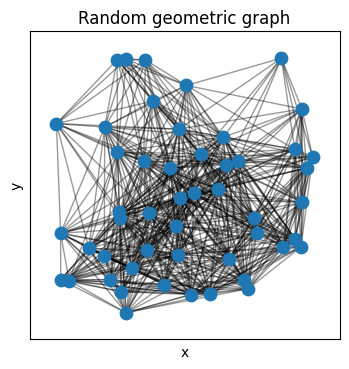

In [7]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
#10, 11, 12, 13， 14
random.seed(14)

device= "cuda:0" if torch.cuda.is_available() else "cpu"

nodeNum= 50#50
popu= [100*int(random.gauss(320, 80)) for i in range(nodeNum)]
radius =0.5#0.5
pos = {i: (random.uniform(0, 1), random.uniform(0, 1)) for i in range(nodeNum)}

popuTen= torch.tensor(popu, dtype= torch.float32, device= device)

def gravity_model(pi, pj, dij, a1=0.1, a2=0.008, r= 30):# from i to j
    return np.exp(a1*np.log(pi)+a2*np.log(pj))*np.exp(-dij*r)

def create_A_mat(weightA, popuT):
    omega= popuT* weightA
    dT= weightA.sum(dim= 1)
    inpop= omega.sum(dim= 1)
    AmatTemp= (dT[:, None]*omega)
    AmatTemp= AmatTemp/(inpop[:, None]+1e-9)#+torch.eye(weightA.shape[0], dtype= torch.float32, device= device)
    return AmatTemp

def reverse_A_mat(A, popuT):
    sumA= A.sum(dim=1)
    tempA= A/popuT
    sumTempA= tempA.sum(dim=1)
    weightA= sumA[:, None]*A/(sumTempA[:, None]*popuT)
    return weightA

G = nx.random_geometric_graph(nodeNum, radius, dim= 2, pos=pos)
print(G.number_of_edges())

weightA= torch.zeros((nodeNum, nodeNum), dtype= torch.float32, device= device)


count= 0
for i,j in G.edges():
    count+= 1
    dx= pos[i][0] - pos[j][0]
    dy= pos[i][1] - pos[j][1]
    dij = np.linalg.norm((dx, dy))
    pi= popu[i]
    pj= popu[j]
    wij= gravity_model(pi, pj, dij)
    if wij> 0.03:
        wij= 0.03
    weightA[i, j]= wij
    wji= gravity_model(pj, pi, dij)
    if wji> 0.03:
        wji= 0.03
    weightA[j, i]= wji

Amat= create_A_mat(weightA, popuTen)
Amat2= reverse_A_mat(Amat, popuTen)
randomList= [random.randint(0, nodeNum-1) for _ in range(nodeNum)]
dimT= 1
print("ZERO:", torch.sum(torch.abs(Amat2-weightA)))

print("ZERO2:", torch.sum(torch.abs(weightA-weightA.T)))

print(torch.sum(Amat>0.2)-nodeNum)
print(torch.sum(Amat>0.1)-nodeNum)
print(torch.sum(Amat>0.01)-nodeNum)
print(count*2)
C= nx.adjacency_matrix(G)
C= C.todense()
plt.figure(figsize=(4, 4))
nx.draw_networkx_edges(G, pos, alpha=0.4)
nx.draw_networkx_nodes(G, pos, node_size=80)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Random geometric graph")
plt.show()

In [8]:
def alpha(i, R, tau):
    return 1-torch.exp(-(R/tau)*i)

def action(state, R0, tau, Amat):
    deltaSIR= torch.zeros_like(state)
    deltaSIR[0]= -state[0]*torch.matmul(Amat, alpha(state[1], R0, tau))
    deltaSIR[2]= state[1]/tau
    deltaSIR[1]= -deltaSIR[0]-deltaSIR[2]
    return state+deltaSIR, -deltaSIR[0]

def one_strain(R0, tau0, timeHorizon, nodeNum,  Amat, time=0, fromS= 0):
    deltaSs= [torch.zeros(nodeNum, dtype=torch.float32, device=device)]
    nodeNum= Amat.shape[0]
    stateNowS= torch.ones(nodeNum, dtype=torch.float32, device=device)
    stateNowI= torch.zeros(nodeNum, dtype=torch.float32, device=device)
    stateNowR= torch.zeros(nodeNum, dtype=torch.float32, device=device)
    stateNow= torch.stack([stateNowS, stateNowI, stateNowR])
    noise= torch.randn((timeHorizon+1), dtype= torch.float32, device=device)/400
    for i in range(timeHorizon):
        if i==time:
            stateNow[0, fromS]= 0.99
            stateNow[1, fromS]= 0.01
            deltaSs[-1][fromS]= 0.01
        stateNow, deltaS= action(stateNow, R0, tau0, Amat)
        deltaSs.append(deltaS.clone())
    deltaSs= torch.stack(deltaSs)#+noise[:, None]
    return deltaSs.T

In [10]:
strains= 2
miniTime= 20
extraDays= 15
timeHorizon= (strains)*miniTime+extraDays
R0s=   [8.37, 8, 6, 8.37, 8]
tau0s= [6.2, 7.5, 7.2, 7.5, 6.2]
for i in range(nodeNum):
    Amat[i, i]= 1
deltaSsList= []
for i in range(strains):
    deltaSsList.append(one_strain(R0s[i%5], tau0s[i%5], timeHorizon, nodeNum, Amat, time= i*20, fromS= randomList[i]))

deltaSsTensor= torch.stack(deltaSsList[0:strains], dim= -1)
deltaSs= deltaSsTensor.sum(dim= -1, keepdim= True)
propition= deltaSsTensor/(deltaSs+1e-8)
deltaSs= deltaSs.squeeze()#(1, 2, 20), dim of nodes, dim of heads, dim of signal
divide= deltaSsTensor.transpose(1, 2)
print(divide.shape)

torch.Size([50, 2, 56])


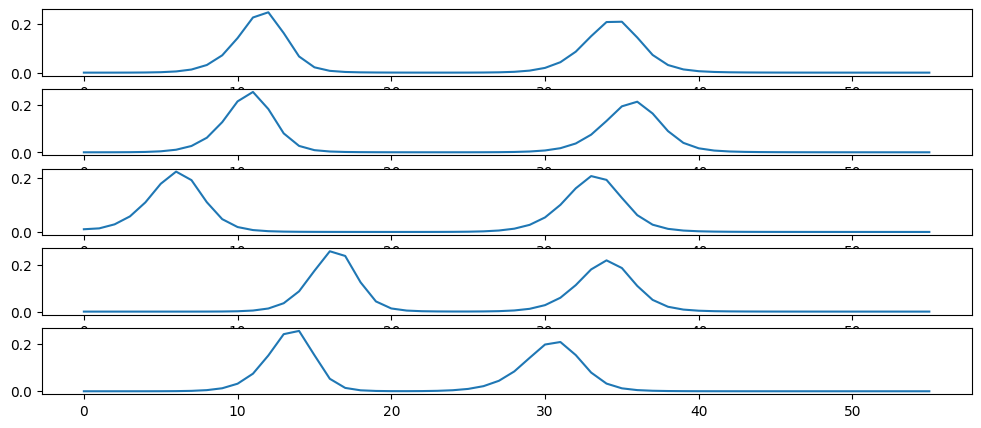

In [11]:
fig, axs = plt.subplots(5, 1, figsize=(12, 5))
for i, ax in enumerate(axs):
    ax.plot(deltaSs[i, :].cpu().detach())


In [12]:
class Epis(torch.nn.Module):
    def __init__(self, input_dim= 20, num_heads= 1, num_nodes= 1, device= "cpu"):
        super(Epis, self).__init__()
        self.device= device
        self.num_heads= num_heads
        self.num_nodes= num_nodes
        self.taus= torch.ones((num_nodes, num_heads), dtype= torch.float32, device=device)*6.2
        self.taus= torch.nn.Parameter(self.taus)
        self.R0dTaus= torch.ones((num_nodes, num_heads), dtype= torch.float32, device=device)*1.35
        self.R0dTaus= torch.nn.Parameter(self.R0dTaus)
        self.Amat= torch.randn((num_nodes, num_nodes), dtype= torch.float32, device=device)- 2
        self.AmatMask= 1- torch.eye(num_nodes, dtype= torch.float32, device=device)
        self.Amateye= torch.eye(num_nodes, dtype= torch.float32, device=device)
        self.Amat= torch.nn.Parameter(self.Amat)
        self.mat, self.mask= self.create_temporal_mat(input_dim)
        self.myRelu= torch.nn.ReLU()
        self.mySig= torch.nn.Sigmoid()
        self.mySoft= torch.nn.Softmax(dim=2)

    def alpha(self, i, R0, tau):
        return 1-torch.exp(-(R0/tau)*i)
    
    def create_temporal_mat(self, lang):
        mat= torch.zeros((lang, lang), dtype= torch.float32, device= self.device)
        mask= torch.zeros((lang, lang), dtype= torch.float32, device= device)
        for i in range(lang):
            for j in range(i+1):
                mat[i, j]= i- j
                mask[i, j]= 1
        return mat[None, None, ...], mask[None, None, ...]

    def forward(self, x, Amat= None): # shape: (1, 2, 20), dim of nodes, dim of heads, dim of signal
        # divide= self.mySoft(self.output)*x[:, :, -1:]#(1, 2, 20), dim of nodes, dim of heads, dim of signal
        # divide= divide.transpose(1, 2)
        if Amat==None:
            tempAmat= self.mySig(self.Amat)*self.AmatMask+ self.Amateye
        else:
            tempAmat= Amat.T
        noise= x[:, 0, :] #\noise delta S
        signal= self.myRelu(x) #\delta S
        Ss= 1- torch.cumsum(signal, dim= -1) #easiy negative
        IsMat= torch.exp(self.mat*torch.log(1-1/self.taus[... , None, None]))*self.mask
        Is= torch.matmul(IsMat, signal[..., None]).squeeze(dim=-1)
        alpha= (1-torch.exp(-self.R0dTaus[... , None]*Is))
        temp= tempAmat[..., None, None]*alpha[:, None, ...]
        Alpha= temp.sum(dim= 0)
        predSignal= Alpha*Ss
        #signalPredict= self.alpha(Is[0: -1], R0, tau)*Ss[0:-1] 
        return predSignal, signal, tempAmat.T
myEpi=Epis(input_dim= timeHorizon+1, num_heads= strains, num_nodes= nodeNum, device= device)
optimizer2 = torch.optim.Adam({myEpi.taus},lr=2e-4)
optimizer3 = torch.optim.Adam({myEpi.Amat},lr=2e-4)
optimizer4 = torch.optim.Adam({myEpi.R0dTaus},lr=2e-4)
myloss= torch.nn.MSELoss(reduction='sum')
losses= []

In [14]:
last10k= []
for j in tqdm(range(50000)):
    optimizer2.zero_grad()
    optimizer3.zero_grad()
    optimizer4.zero_grad()
    predSignal, signal, tempAmat= myEpi(divide)
    loss= myloss(predSignal[:, :, 0:-1], signal[:, :, 1:])*10+ torch.var(myEpi.taus, dim= 0).sum()\
        + torch.var(myEpi.R0dTaus, dim= 0).sum()
    losses.append(loss.item())
    loss.backward(retain_graph=True)
    optimizer2.step()
    optimizer3.step()
    optimizer4.step()
print(loss/timeHorizon*100)#
#1， 2， 3， 4

#0.1451, 0.2211, 0.2898, 0.3448

 20%|█▉        | 9784/50000 [00:53<03:38, 183.66it/s]


KeyboardInterrupt: 

In [28]:
thred= 1e-5
print(myEpi.taus[0])
print((myEpi.taus*myEpi.R0dTaus)[0])
print("err1:", torch.abs(tempAmat-Amat).sum())
print("err2:", ((tempAmat>thred)^(Amat>thred)).sum())
print(torch.var(myEpi.taus, dim= 0))
print(torch.var(myEpi.R0dTaus, dim= 0))
print(torch.sum(predSignal[29, :, 0:-1])/strains)
print(torch.sum(signal[29, :, 1:])/strains)
startV= 5
deltaV= 5
#print(inferAmat[startV:startV+deltaV, startV:startV+deltaV])
#print(Amat[startV:startV+deltaV, startV:startV+deltaV])
#print(tempAmat)
lossDirect= np.array([[0.1451, 0.2211, 0.2898, 0.3448]])
err1Direct= np.array([[301.1207, 385.5265, 464.9998, 519.5751]])
err2Direct= np.array([[1491, 1451, 1382, 1391]])

lossAtt= np.array([[0.0145, 0.0073, 0.0066, 0.0050]])
err1Att= np.array([[17.4788, 5.8208, 4.3792, 3.0708]])
err2Att= np.array([[847, 622, 435, 389]])

tensor([ 9.0927, 10.1596,  9.0678,  9.3340], grad_fn=<SelectBackward0>)
tensor([ 4.7122,  0.4243, -0.3251,  1.8681], grad_fn=<SelectBackward0>)
err1: tensor(519.5751, grad_fn=<SumBackward0>)
err2: tensor(1391)
tensor([9.9284e-06, 6.5201e-06, 3.5693e-06, 4.5530e-06],
       grad_fn=<VarBackward0>)
tensor([0.0672, 0.0550, 0.0362, 0.0576], grad_fn=<VarBackward0>)
tensor(0.9988, grad_fn=<DivBackward0>)
tensor(0.9993)


C:\Users\30678\AppData\Local\Temp\ipykernel_25320\698980313.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  err1s=np.array([[301.1207, 385.5265, 464.9998],
C:\Users\30678\AppData\Local\Temp\ipykernel_25320\698980313.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  err2s=np.array([[1491, 1451, 1382],


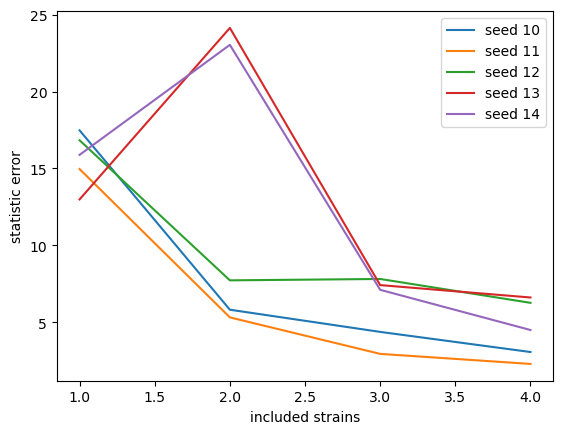

In [34]:
plt.plot([i+1 for i in range(4)],err1s.T, label=["seed 10", "seed 11", "seed 12", "seed 13", "seed 14"])
plt.ylabel("statistic error")
plt.xlabel("included strains")
plt.legend()

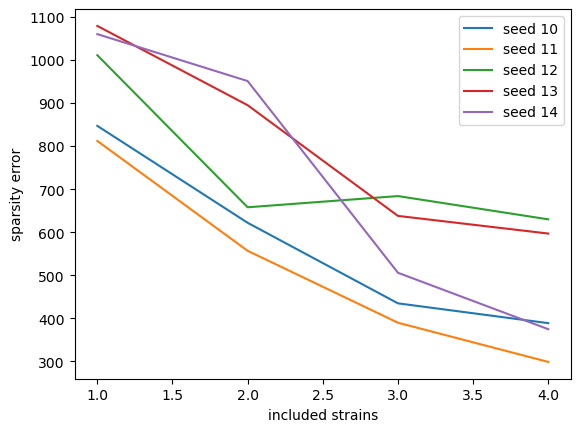

In [45]:
plt.plot([i+1 for i in range(4)],err2s.T, label=["seed 10", "seed 11", "seed 12", "seed 13", "seed 14"])
plt.ylabel("sparsity error")
plt.xlabel("included strains")
plt.legend()

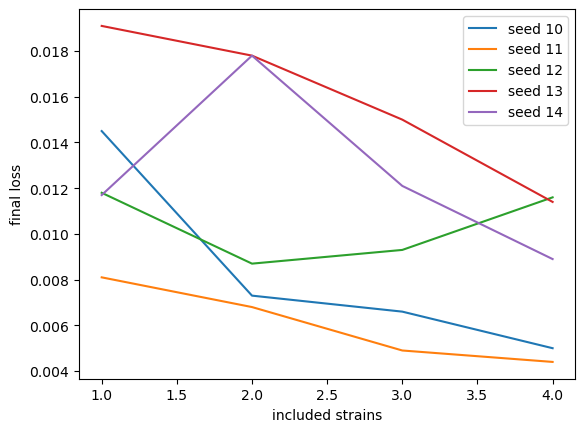

In [43]:
plt.plot([i+1 for i in range(4)],finalLoss.T, label=["seed 10", "seed 11", "seed 12", "seed 13", "seed 14"])
plt.ylabel("final loss")
plt.xlabel("included strains")
plt.legend()

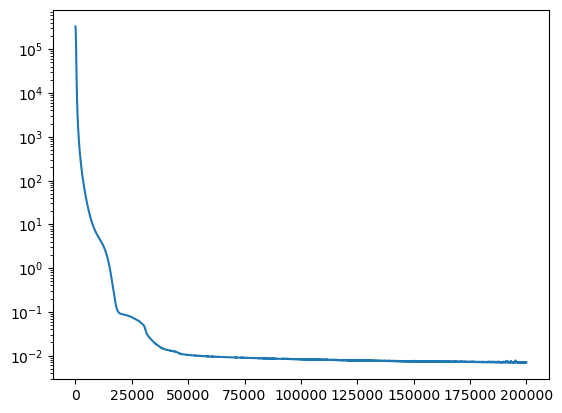

In [25]:

plt.plot(losses)
plt.yscale("log")

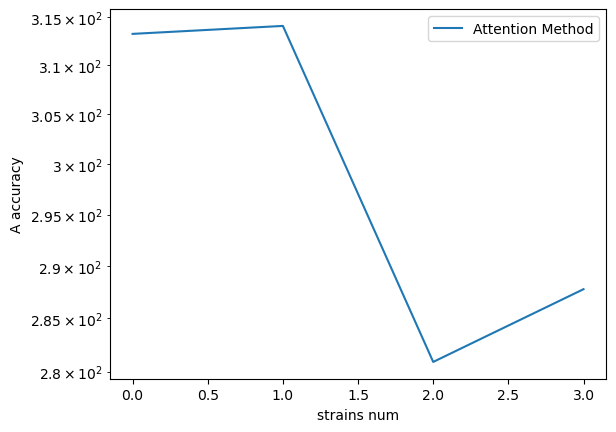

In [413]:
plt.plot(exper, label= "Attention Method")
#plt.plot(exper2, label= "Direct Method")
plt.xlabel("strains num")
plt.ylabel("A accuracy")
plt.yscale("log")
plt.legend()

[10, 25, 45, 36, 41, 45, 26, 45, 41, 32, 9, 19, 7, 8, 49, 39, 41, 8, 23, 2, 46, 10, 34, 48, 13, 40, 27, 12, 24, 9, 24, 35, 20, 18, 15, 20, 11, 47, 40, 47, 34, 31, 40, 36, 34, 32, 45, 40, 21, 28]
tensor(4.5935e-06, device='cuda:0')
tensor(1.1174e-05, device='cuda:0', grad_fn=<SelectBackward0>)


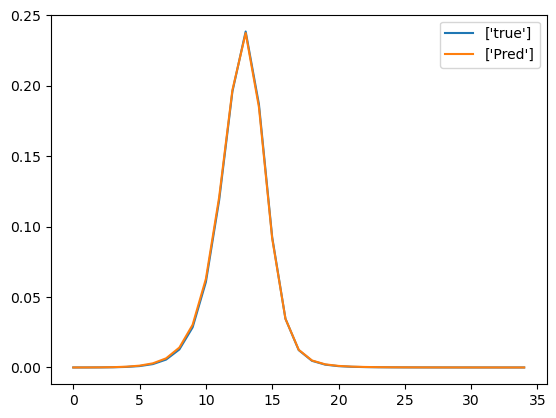

In [646]:
print(randomList)
node= 4
plt.plot(signal[node, :, 1:].squeeze().T.cpu().detach(), label=strains*["true"])
print(signal[node, 0, 1])
print(predSignal[node, 0, 0])
#plt.plot(embedded_tensor[0, :, -1:].squeeze().T.cpu().detach())
plt.plot(predSignal[node, :, 0:-1].squeeze().T.cpu().detach(), label=strains*["Pred"])
#plt.plot(noise[0].T.cpu().detach())
plt.legend()

In [54]:
print(predSignal)

tensor([[[ 2.8981e-04,  6.5643e-04,  1.1764e-03,  ..., -4.8123e-06,
          -2.5756e-06, -1.3793e-06],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 1.7367e-04,  3.9734e-04,  7.1843e-04,  ..., -0.0000e+00,
          -0.0000e+00, -0.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 1.2435e-02,  2.8584e-02,  5.2121e-02,  ..., -0.0000e+00,
          -0.0000e+00, -0.0000e+00],
         [ 2.1886e-03,  2.1981e-03,  1.6178e-03,  ...,  4.9977e-07,
           2.6761e-07,  1.4305e-07]]], grad_fn=<MulBackward0>)
